In [105]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import sklearn
np.random.seed(0)

In [104]:
training = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

training = training.iloc[:, 1:]

test = test.iloc[:, 1:]

In [101]:
def onehot_feature(pd_data, column_name):
    # Retrieve the unique values (the categories) and an index for each sample
    # specifying the sample category (values[value_idx] reconstruct the original array)
    col_values = pd_data[column_name].to_numpy().astype('<U')
    values, value_idx = np.unique(col_values, return_inverse=True)
    n_values = values.size
    # Create a temporary identity matrix to convert value_idx into one-hot features
    onehots = np.eye(n_values) #when you use an array to index another array in NumPy, it selects rows from the indexed array based on the values in the index array. e[a] selects rows from the identity matrix e based on the values in array a
    value_onehot = onehots[value_idx]
    # Remove the categorical feature
    pd_data = pd_data.drop(column_name, axis=1)
    # Add the new featues
    for i in range(n_values):
        pd_data["{}_{}".format(column_name, values[i])] = value_onehot[:, i]
        
    return pd_data

In [102]:
training = onehot_feature(training, 'DNAtype')
test = onehot_feature(test, 'DNAtype')

training = training.drop(["SpeciesID", "SpeciesName"], axis = 1)
test = test.drop(["SpeciesID", "SpeciesName"], axis = 1)


We remove the AGA feature from the training set (we will use it at point 4.)

In the test set we add all 0 columns for the DNA type missing (given the fact that a sample with DNA type = 2, is for sure 0 for all others DNA types). We have to do this otherwise the function complains.

In [96]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
#from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import re

# Divide il dataset in feature e target
X = training.drop(["Kingdom", "AGA"], axis = 1)  # Feature
y = training['Kingdom']  # Target

# Adding missing columns for DNA type
pattern = r'DNAtype_\d+'
set_colnames_training = set()
for col in training.columns.tolist():
    if re.match(pattern, col):
        set_colnames_training.add(col)
set_colnames_test = set()
for col in test.columns.tolist():
    if re.match(pattern, col):
        set_colnames_test.add(col)
missing_columns_in_test = list(set_colnames_training.difference(set_colnames_test.intersection(set_colnames_training)))
for col in missing_columns_in_test:
    test[col] = 0

X_test = test.drop(columns = ['Kingdom'])
y_test = test['Kingdom']

X_test = X_test[X.columns]


# Crea un'istanza del modello LDA
model = LDA(store_covariance=True)

# Addestra il modello LDA
model.fit(X, y)

# Valuta il modello
train_accuracy = accuracy_score(y, model.predict(X))

test_accuracy = accuracy_score(y_test, model.predict(X_test))

print("Train accuracy:", train_accuracy)
print("Test accuracy:", test_accuracy)


Train accuracy: 0.8164459796584149
Test accuracy: 0.8069838833461244


In [52]:
from math import atan, degrees
from matplotlib import colors
from matplotlib.pyplot import cm
import matplotlib.patches as mpatches

def plot_gaussian(model, mu, covar, x, y=None, n_stdev_bands=2):
    if not isinstance(x, np.ndarray):
        x = np.array(x)
    if covar.ndim == 2:
        covar = np.repeat(covar[None], mu.shape[0], axis=0)
        
    # Confidence Ellipses
    # ===================
    
    ax = plt.subplot(111, aspect='equal')
    legend = []
    # We plot the distributions only if we are
    # using just 2 features (see next section)
    if mu.shape[-1] == 2:
        # 1- Compute the rotation and the variance 
        #    in the new rotated coordinate system
        # ========================================
        variance, transforms = np.linalg.eigh(covar)
        # 2- Compute the standard deviations
        # ==================================
        stdev = np.sqrt(variance)
        
        max_x, min_x, max_y, min_y = 0.0, 0.0, 0.0, 0.0
        cmap = cm.rainbow(np.linspace(0, 1, mu.shape[0]))
        for mean, stdev, transform, color in zip(mu, stdev, transforms, cmap):
            # We collect some labels to print in the legend
            legend += [mpatches.Patch(color=color,
                                      label=f'mu {mean[0]:.2f}, {mean[1]:.2f} '
                                      f'sigma {stdev[0]:.2f} {stdev[1]:.2f}')]
            # We compute several confidence ellipses
            # multiple of the standard deviation
            for j in range(1, n_stdev_bands + 1):
                # 3- Plot the ellipses
                # ==================================
                ell = mpatches.Ellipse(xy=(mu[0], mu[1]), # The center position (xc, yc)
                                       # The width and height:
                                       # axis-aligned standard deviation (multiple of 2*j)
                                       width=stdev[0] * j * 2, height=stdev[1] * j * 2,
                                       # The rotation angle degree(atan(v1/v0))
                                       angle=degrees(atan(transform[0, 1] / transform[0, 0])),
                                       # Color properties and transparency
                                       alpha=1.0, edgecolor=color, fc='none')
                ax.add_artist(ell)
                # Compute the picture size based on how many bands
                # we plotted
                max_x = max(max_x, mean[0] + stdev[0] * j * 1.5)
                max_y = max(max_y, mean[1] + stdev[1] * j * 1.5)
                min_x = min(min_x, mean[0] - stdev[0] * j * 1.5)
                min_y = min(min_y, mean[1] - stdev[1] * j * 1.5)
    else:
        # Otherwise just compute the plot boundaries
        max_x, min_x = x[:, 0].max()+x[:, 0].ptp()/2, x[:, 0].min()-x[:, 0].ptp()/2
        max_y, min_y = x[:, 1].max()+x[:, 1].ptp()/2, x[:, 1].min()-x[:, 1].ptp()/2
        
    # Boundaries 
    # ==========
    # A part from the actual boundary, we also want to
    # color the space regions with the same color as the
    # predicted class!
    # Given the picture size x \in [min_x, max_x], y \in [min_y, max_y]
    # we sample the space at regular intervals and create a fake dataset
    # with features that cover all the space.
    # The meshgrid function takes two array (a ruler on the two axis),
    # combine them and return two matrices of shape [y_size, x_size]
    # containing all the x coordinates (the first) and all the y coordinates
    xx, yy = np.meshgrid(np.linspace(min_x, max_x, 1000),
                         np.linspace(min_y, max_y, 1000))
    # xx.shape = [1000, 1000], yy.shape = [1000,1000]
    # Merge the features and convert in the usual [Nsample, Nfeatures] shape
    X_fake = np.stack([xx, yy], axis=-1).reshape(-1, 2)
    # Predict the probability
    Z = model.predict_proba(X_fake)
    # And convert values back into a 2D grid for visualization
    Z = Z[:, 1].reshape(xx.shape)
    
    cmap_light = colors.ListedColormap(['#AAAAFF', '#FFAAAA'])
    cmap_solid = colors.ListedColormap(['#0000FF', '#FF0000'])
    # Color the background: pcolormesh colors the background using
    # the grid coordinates and the predicted probability as color
    # eventually filling gaps
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light, norm=colors.Normalize(0., 1.))
    # We also plot the contour where the color changes with a grey line
    plt.contour(xx, yy, Z, [0.5], colors='grey')
    # Plot the point
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap=cmap_solid)
    ax.set_xlim(min_x, max_x)
    ax.set_ylim(min_y, max_y)
    plt.gca().set_aspect('equal', adjustable='box')
    if legend:
        plt.legend(handles=legend)

    plt.show()

IndexError: index 1 is out of bounds for axis 1 with size 1

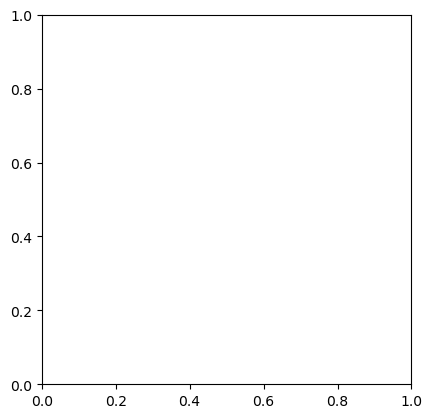

In [53]:
plot_gaussian(model, model.means_, model.covariance_, X_train, y_train)

In [55]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

model = Pipeline([
    ('poly', PolynomialFeatures(degree=2)),
    ('lda', LDA(store_covariance=True))])
model = model.fit(X_train, y_train)

print("Train accuracy:", accuracy(y_train, model.predict(X_train)))
#print("Test accuracy:", accuracy(y_test, model.predict(X_test)))

Train accuracy: 0.7791771620486986


IndexError: index 1 is out of bounds for axis 1 with size 1

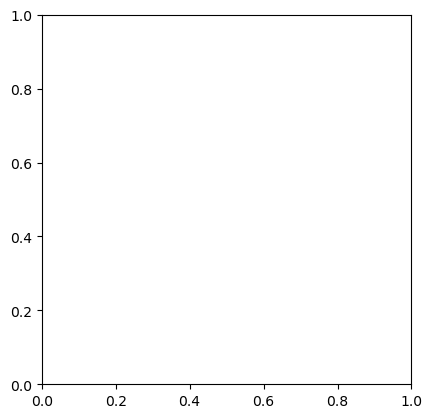

In [56]:
lda_model = model.steps[-1][-1]
plot_gaussian(model, lda_model.means_, lda_model.covariance_, X_train, y=y_train)

In [64]:
from sklearn.model_selection import GridSearchCV

model = Pipeline([('poly', PolynomialFeatures()),
                  ('lda', LDA(store_covariance=True))])
params = {'poly__degree': range(1, 6)}
cv = GridSearchCV(model, params, refit=True, cv=10, 
                  scoring=make_scorer(accuracy))
cv.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('poly', PolynomialFeatures()),
                                       ('lda',
                                        LinearDiscriminantAnalysis(store_covariance=True))]),
             param_grid={'poly__degree': range(1, 6)},
             scoring=make_scorer(accuracy, response_method='predict'))

In [65]:
cv.best_params_
cv.best_score_
pd.DataFrame(cv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_poly__degree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.011072,0.008623,0.002266,0.004925,1,{'poly__degree': 1},0.776978,0.776978,0.776978,0.776978,0.776978,0.776978,0.776978,0.777911,0.777911,0.777911,0.777258,0.000427,4
1,0.012504,0.006252,0.001562,0.004687,2,{'poly__degree': 2},0.776978,0.776978,0.779376,0.779376,0.778177,0.775779,0.778177,0.783914,0.783914,0.779112,0.779178,0.002611,2
2,0.010933,0.007158,0.004688,0.007161,3,{'poly__degree': 3},0.774580,0.776978,0.782974,0.780576,0.778177,0.775779,0.775779,0.783914,0.782713,0.782713,0.779418,0.003366,1
3,0.003127,0.006255,0.007811,0.007811,4,{'poly__degree': 4},0.773381,0.776978,0.782974,0.779376,0.776978,0.775779,0.775779,0.783914,0.776711,0.782713,0.778458,0.003416,3
4,0.004688,0.007161,0.007813,0.007813,5,{'poly__degree': 5},0.770983,0.775779,0.782974,0.781775,0.772182,0.772182,0.774580,0.782713,0.779112,0.779112,0.777139,0.004357,5


In [68]:
def show_results(cv, X_test, params, prefix=''):
    prefix = ' '+prefix    
    results = pd.DataFrame(cv.cv_results_)
    # Plot the CV (mean) scores for all possible parameters
    plt.plot(results[f'param_{params}'], results['mean_test_score'], label=prefix)

    # Find the best
    best_idx = np.argmax(results['mean_test_score'])
    # Plot it as a cross
    plt.plot(results[f'param_{params}'][best_idx], results['mean_test_score'][best_idx], marker='X')
    plt.legend()

    print(prefix, f"(best {results[params][best_idx]}) CV accuracy:",  cv.best_score_)
    print(prefix, f"(best {results[params][best_idx]}) Test accuracy:", accuracy(y_test, cv.best_estimator_.predict(X_test)))
    
show_results(cv, X_test, 'param_poly__degree')

KeyError: 'param_param_poly__degree'

In [71]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

model = QDA()
model = model.fit(X_train, y_train)

print("Train accuracy:", accuracy(y_train, model.predict(X_train)))
#print("Test accuracy:", accuracy(y_test, model.predict(X_test)))

plot_gaussian(model, model.means_, np.stack(model.covariance_, axis=0), X_train, y_train, 2)

Train accuracy: 0.7750989564591579


AttributeError: 'QuadraticDiscriminantAnalysis' object has no attribute 'covariance_'

In [73]:
from sklearn.neighbors import KNeighborsClassifier

# Define a list of k values to try
k_values = [1, 3, 5, 7, 9]

# Dictionary to store train and test accuracies for each k
accuracy_results = {'k': [], 'train_accuracy': [], 'test_accuracy': []}

for k in k_values:
    # Train the KNN classifier with the current value of k
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train)
    
    # Compute train and test accuracies
    train_accuracy = accuracy(y_train, model.predict(X_train))
    #test_accuracy = accuracy(y_test, model.predict(X_test))
    
    # Store the results
    accuracy_results['k'].append(k)
    accuracy_results['train_accuracy'].append(train_accuracy)
    #accuracy_results['test_accuracy'].append(test_accuracy)
    
    print(f"For k = {k}:")
    print("Train accuracy:", train_accuracy)
   # print("Test accuracy:", test_accuracy)

For k = 1:
Train accuracy: 0.8198392707208828
For k = 3:
Train accuracy: 0.8261964735516373
For k = 5:
Train accuracy: 0.8014873455679501
For k = 7:
Train accuracy: 0.8016072927911719
For k = 9:
Train accuracy: 0.7984886649874056


In [81]:
print("TEST\n",X_test.head())
print("\nTRAINING\n",X.head())
print(training.columns[training.columns=='AGA'])

TEST
    Ncodons      UUU      UUC      UUA      UUG      CUU      CUC      CUA  \
0   568103  0.00959  0.01359  0.01584  0.01312  0.02491  0.02457  0.01885   
1     6295  0.01223  0.03447  0.00508  0.01811  0.01176  0.02335  0.00413   
2     3451  0.01014  0.03014  0.00145  0.01275  0.01420  0.02521  0.00261   
3    14867  0.03551  0.02892  0.00155  0.01117  0.01224  0.02475  0.00511   
4     1143  0.01662  0.01400  0.02800  0.03412  0.01312  0.02625  0.02100   

       CUG      AUU  ...      GAG      UAA      UAG      UGA  DNAtype_0  \
0  0.01269  0.01319  ...  0.03877  0.01183  0.00061  0.00117        1.0   
1  0.02017  0.01334  ...  0.03066  0.03479  0.00064  0.00064        1.0   
2  0.01101  0.02492  ...  0.01826  0.03216  0.00116  0.00029        1.0   
3  0.02233  0.01392  ...  0.03390  0.01628  0.00108  0.00047        1.0   
4  0.01137  0.03412  ...  0.01575  0.02625  0.00087  0.00525        0.0   

   DNAtype_1  DNAtype_11  DNAtype_2  DNAtype_4  DNAtype_5  
0        0.0        

0       bct
1       inv
2       pln
3       pln
4       pln
       ... 
2601    mam
2602    bct
2603    vrt
2604    bct
2605    mam
Name: Kingdom, Length: 2606, dtype: object

In [98]:
X_test

,Ncodons,UUU,UUC,UUA,UUG,CUU,CUC,CUA,CUG,AUU,...,DNAtype_1,DNAtype_11,DNAtype_12,DNAtype_2,DNAtype_3,DNAtype_4,DNAtype_5,DNAtype_6,DNAtype_7,DNAtype_9
0,568103,0.00959,0.01359,0.01584,0.01312,0.02491,0.02457,0.01885,0.01269,0.01319,...,0.0,0.0,0,0.0,0,0.0,0.0,0,0,0
1,6295,0.01223,0.03447,0.00508,0.01811,0.01176,0.02335,0.00413,0.02017,0.01334,...,0.0,0.0,0,0.0,0,0.0,0.0,0,0,0
2,3451,0.01014,0.03014,0.00145,0.01275,0.01420,0.02521,0.00261,0.01101,0.02492,...,0.0,0.0,0,0.0,0,0.0,0.0,0,0,0
3,14867,0.03551,0.02892,0.00155,0.01117,0.01224,0.02475,0.00511,0.02233,0.01392,...,0.0,0.0,0,0.0,0,0.0,0.0,0,0,0
4,1143,0.01662,0.01400,0.02800,0.03412,0.01312,0.02625,0.02100,0.01137,0.03412,...,0.0,0.0,0,1.0,0,0.0,0.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2601,8361,0.00694,0.02021,0.00993,0.01316,0.01435,0.01973,0.00921,0.03720,0.01794,...,0.0,0.0,0,0.0,0,0.0,0.0,0,0,0
2602,1537469,0.01400,0.02160,0.01327,0.02326,0.01459,0.00924,0.00480,0.02757,0.02659,...,0.0,0.0,0,0.0,0,0.0,0.0,0,0,0
2603,1516,0.00264,0.05079,0.02243,0.00132,0.03034,0.07190,0.04156,0.00264,0.03958,...,1.0,0.0,0,0.0,0,0.0,0.0,0,0,0
2604,1195,0.00000,0.00502,0.05021,0.00837,0.01841,0.01757,0.00586,0.00167,0.03849,...,0.0,0.0,0,0.0,0,0.0,0.0,0,0,0
